In [1]:
import random
import numpy as np
import networkx as nx
import igraph as ig
from igraph import Graph
import matplotlib.pyplot as plt
from pprint import pprint

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_geometric.nn as tgnn

from models.models import GCN

In [2]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print (device)

In [3]:
def generate_random_ER_graph(N=1000, n=50, p=0.10):
    all_er_graphs = []
    for i in range(N):
        p = torch.rand(1).item()
        graph = Graph.Erdos_Renyi(n, p)
        all_er_graphs.append([graph, n, p])

    return all_er_graphs

def count_triangles(adj):
    new_graph = nx.from_numpy_matrix(adj)
    counts = nx.triangles(new_graph)
    n_tri = sum(counts.values()) // 3

    return n_tri

def encode_graphs(graphs, N=1000, n=50):
    all_features = torch.Tensor(N, n, 1)
    all_labels = torch.Tensor(N, 1)

    all_data = []

    for i in range(N):
        graph, n, p = graphs[i]
        node_count = graph.vcount()
        adj = np.array(list(graph.get_adjacency()))
        edge_idx, edge_wt = tg.utils.dense_to_sparse(torch.from_numpy(adj))

        features = torch.zeros(size=(node_count, 1))

        """
        Get number of triangles from current graph
        """
        label = count_triangles(adj)

        all_features[i] = features
        all_labels[i] = label

        temp = tg.data.Data(
            x=all_features,
            y=all_labels,
            edge_index=edge_idx,
        )

        all_data.append(temp)

    return all_data

graphs = generate_random_ER_graph()
all_data = encode_graphs(graphs)
pprint (all_data[:5])

[Data(x=[1000, 50, 1], edge_index=[2, 1718], y=[1000, 1]),
 Data(x=[1000, 50, 1], edge_index=[2, 56], y=[1000, 1]),
 Data(x=[1000, 50, 1], edge_index=[2, 2404], y=[1000, 1]),
 Data(x=[1000, 50, 1], edge_index=[2, 774], y=[1000, 1]),
 Data(x=[1000, 50, 1], edge_index=[2, 2386], y=[1000, 1])]


In [4]:
class GCN(nn.Module):
    def __init__(self, indim, hidden, outdim):
        super().__init__()
        self.conv1 = tgnn.GraphConv(indim, hidden)
        self.conv2 = tgnn.GraphConv(hidden, hidden)
        self.conv3 = tgnn.GraphConv(hidden, outdim)

    def forward(self, x, edge_idx):
        x = torch.relu(self.conv1(x, edge_idx))
        x = torch.relu(self.conv2(x, edge_idx))
        out = self.conv3(x, edge_idx)

        return out

In [19]:
model = GCN(50, 32, 1).to(device)
optim = torch.optim.Adam(model.parameters())
loss = nn.MSELoss()

EPOCHS = 10
SAVEPATH = "figures/"

In [13]:
gcn_mse = []

for epoch in range(EPOCHS):
    print (f"Epoch {epoch}")
    temp_gcn_mse = []
    for data in all_data:
        data = data.to(device)
        optim.zero_grad()
        pred = model(data.x.view(-1, 50), data.edge_index)
        curloss = loss(pred.view(-1), data.y.view(-1))
        curloss.backward()
        temp_gcn_mse.append(curloss.cpu().item())
        optim.step()
        
    gcn_mse.append(np.asarray(temp_gcn_mse).mean())

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [20]:
def plots(modelname, epochs, mseloss, savepath):
    fig = plt.figure(figsize=(11, 7), dpi=80)

    plt.plot(epochs, mseloss, linewidth=2, linestyle='-', marker='*', markersize=9, label='GCN')

    plt.title(f"{modelname} | SUBSTRUTURE")
    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('linear')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('MSE Loss', fontsize=20)
    plt.ylabel('Epochs', fontsize=20)
    # plt.show()
    
    fig.savefig(savepath + f"{modelname}_substructure_mse.pdf", dpi=400, bbox_inches='tight')

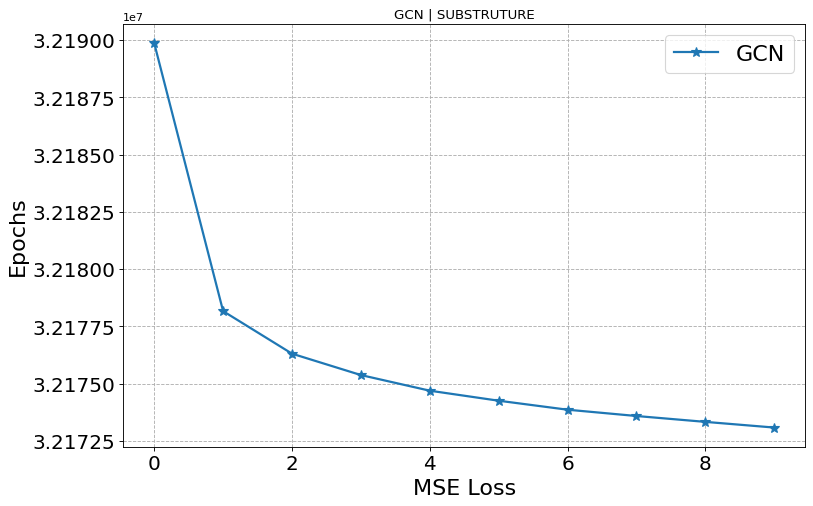

In [21]:
plots("GCN", range(EPOCHS), gcn_mse, SAVEPATH)